In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import requests
import re
from datetime import datetime
import pandas as pd

In [3]:
import geopandas as gpd

In [4]:
import contextily as cx
import rasterio
from rasterio.plot import show as rioshow
import matplotlib.pyplot as plt

In [19]:
import math

In [3]:
## Get the Data

# The National Observatory of Athens has an earthquake catalog; for each year there is a txt file with all the earthquakes in Greece
noa_url = 'https://www.gein.noa.gr/HTML/Noa_cat/CAT2021.TXT'

with open('Data/CAT2021.TXT', mode='w') as f:
    try:
        f.write((response := requests.get(noa_url)).text)
        response.status_code
    except Exception as e:
        print('Website currently not available')

1503489

200

In [3]:
# examine the data
with open('Data/CAT2021.TXT', 'r') as data:
    _ = [print(data.readline()) for _ in range(10)]

 DATE         TIME     LAT.   LONG.  DEPTH    MAGNITUDE            



                   (GMT)    (N)    (E)    (km)       (Local)



 2021 JAN  1   00 38 24.3 38.3894 21.9832    8         1.2



 2021 JAN  1   00 57 47.9 38.3748 22.0290    8         0.8



 2021 JAN  1   01 09 25.7 38.3693 22.0290    7         1.6





In [ ]:
# so the text file of earthquakes for 2021 contains 6 columns separated by space
# cleaning will require distinguishing the columns as not every space delinates one column

In [5]:
# from text lines to pandas dataframe...

with open('Data/CAT2021.TXT', 'r', encoding='UTF-8') as f:

    # initialize 6 lists to hold the column data
    date_str = []
    time_str = []
    lat_str = []
    lon_str = []
    depth_str = []
    man_str = []

    # iterate across rows
    while (line := f.readline()):
        # regular expression to delineate columns in each row
        p = re.compile(r'^(\s+\d{4}\s+[A-Z]{3}\s+\d{1,2})\s+(\d{2}\s+\d{2}\s+[\d.]+)\s+([\d.]+)\s+([\d.]+)\s+(\d+)\s+([\d.]+)$')
        # (\s+\d{4}\s+[A-Z]{3}\s+\d{1,2})  : date
        # (\d{2}\s+\d{2}\s+[\d.]+)         : time
        # ([\d.]+)                         : latitude
        # ([\d.]+)                         : longitude
        # (\d+)                            : depth
        # ([\d.]+)                         : magnitude
        
        if (vals := [i.strip() for tup in p.findall(line) for i in tup]) == []:
            # skip the first 2 lines
            continue
        else:
            date_str.append(vals[0])
            time_str.append(vals[1])
            lat_str.append(vals[2])
            lon_str.append(vals[3])
            depth_str.append(vals[4])
            man_str.append(vals[5])
    
        
    earthquakes_df = pd.DataFrame({'DATE': [datetime.strptime(d, '%Y %b %d').strftime('%d/%m/%Y') for d in date_str],
                       'TIME(GMT)': [datetime.strptime(t, '%H %M %S.%f').strftime('%H:%M:%S.%f') for t in time_str],
                       'LAT (N)': [float(lat) for lat in lat_str],
                       'LONG (E)': [float(lon) for lon in lon_str],
                       'DEPTH(km)': [int(d) for d in depth_str],
                       'MAGNITUDE(Local)': [float(m) for m in man_str]})

In [6]:
earthquakes_df.head()
earthquakes_df.tail()
print(f"rows:{earthquakes_df.shape[0]}, columns:{earthquakes_df.shape[1]}")

,DATE,TIME(GMT),LAT (N),LONG (E),DEPTH(km),MAGNITUDE(Local)
0,01/01/2021,00:38:24.300000,38.3894,21.9832,8,1.2
1,01/01/2021,00:57:47.900000,38.3748,22.0290,8,0.8
2,01/01/2021,01:09:25.700000,38.3693,22.0290,7,1.6
3,01/01/2021,01:28:31.000000,40.4311,21.1546,17,2.1
4,01/01/2021,01:53:23.600000,34.9503,24.3283,45,1.9


,DATE,TIME(GMT),LAT (N),LONG (E),DEPTH(km),MAGNITUDE(Local)
25051,31/12/2021,22:55:36.600000,36.4554,27.1024,16,2.8
25052,31/12/2021,23:03:08.800000,38.3492,21.8285,8,0.9
25053,31/12/2021,23:31:57.500000,38.7584,23.3235,11,1.7
25054,31/12/2021,23:36:13.500000,35.0807,25.1921,12,1.7
25055,31/12/2021,23:36:34.000000,35.0880,25.2168,13,1.9


rows:25056, columns:6


In [7]:
# Prepare dataframe to create GeoDataFrame:
# create well known text geometry column from lat & long
earthquakes_df['wkt'] = [f"POINT ({earthquakes_df['LONG (E)'][i]} {earthquakes_df['LAT (N)'][i]})" for i in range(len(earthquakes_df))]
earthquakes_df.head()

,DATE,TIME(GMT),LAT (N),LONG (E),DEPTH(km),MAGNITUDE(Local),wkt
0,01/01/2021,00:38:24.300000,38.3894,21.9832,8,1.2,POINT (21.9832 38.3894)
1,01/01/2021,00:57:47.900000,38.3748,22.0290,8,0.8,POINT (22.029 38.3748)
2,01/01/2021,01:09:25.700000,38.3693,22.0290,7,1.6,POINT (22.029 38.3693)
3,01/01/2021,01:28:31.000000,40.4311,21.1546,17,2.1,POINT (21.1546 40.4311)
4,01/01/2021,01:53:23.600000,34.9503,24.3283,45,1.9,POINT (24.3283 34.9503)


In [8]:
# Create geometry from well known text to be used in GeoDataFrame
geom = gpd.GeoSeries.from_wkt(earthquakes_df['wkt'])

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(earthquakes_df, geometry=geom, crs="EPSG:4326")
gdf.head()

,DATE,TIME(GMT),LAT (N),LONG (E),DEPTH(km),MAGNITUDE(Local),wkt,geometry
0,01/01/2021,00:38:24.300000,38.3894,21.9832,8,1.2,POINT (21.9832 38.3894),POINT (21.98320 38.38940)
1,01/01/2021,00:57:47.900000,38.3748,22.0290,8,0.8,POINT (22.029 38.3748),POINT (22.02900 38.37480)
2,01/01/2021,01:09:25.700000,38.3693,22.0290,7,1.6,POINT (22.029 38.3693),POINT (22.02900 38.36930)
3,01/01/2021,01:28:31.000000,40.4311,21.1546,17,2.1,POINT (21.1546 40.4311),POINT (21.15460 40.43110)
4,01/01/2021,01:53:23.600000,34.9503,24.3283,45,1.9,POINT (24.3283 34.9503),POINT (24.32830 34.95030)


In [9]:
# mask will be used to clip the GeoDataFrame to the area of interest
mask = gpd.GeoSeries.from_file('Data/mask.geojson')
mask

0    POLYGON ((24.64051 34.79134, 24.64051 35.57831...
Name: geometry, dtype: geometry

In [10]:
mask.total_bounds
mask.crs

array([24.64050934, 34.79133637, 25.844812  , 35.57830643])

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
mask.to_crs(epsg=3857).total_bounds

array([2742968.95229808, 4135560.62207064, 2877031.31096351,
       4242751.05244047])

In [12]:
# download a CartoDB basemap based on mask boundaries

w, s, e, n = mask.to_crs(epsg=3857).total_bounds

# using the above coordinates download the basemap in tif format 
_ = cx.bounds2raster(w, s, e, n,
                    ll=False,
                    zoom=12,
                    path='Data/heraklion_no_labels.tif',
                    source=cx.providers.CartoDB.PositronNoLabels
                    )
_ = cx.bounds2raster(w, s, e, n,
                    ll=False,
                    zoom=12,
                    path='Data/heraklion_only_labels.tif',
                    source=cx.providers.CartoDB.PositronOnlyLabels
                    )

In [13]:
# clip the data to the mask extend
quakes = gpd.clip(gdf,mask)
quakes.shape

(4601, 8)

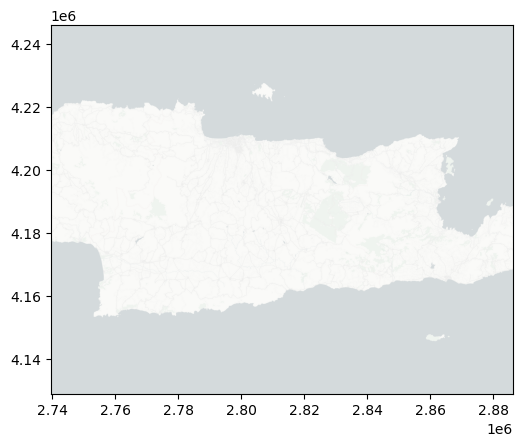

<Axes: >

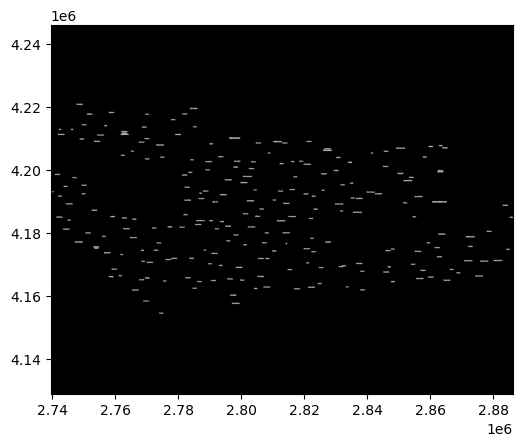

<Axes: >

In [20]:
with rasterio.open('Data/heraklion_no_labels.tif') as h:
    rioshow(h)
with rasterio.open('Data/heraklion_only_labels.tif') as h:
    rioshow(h)

In [20]:
symbol_size = math.e**quakes['MAGNITUDE(Local)']

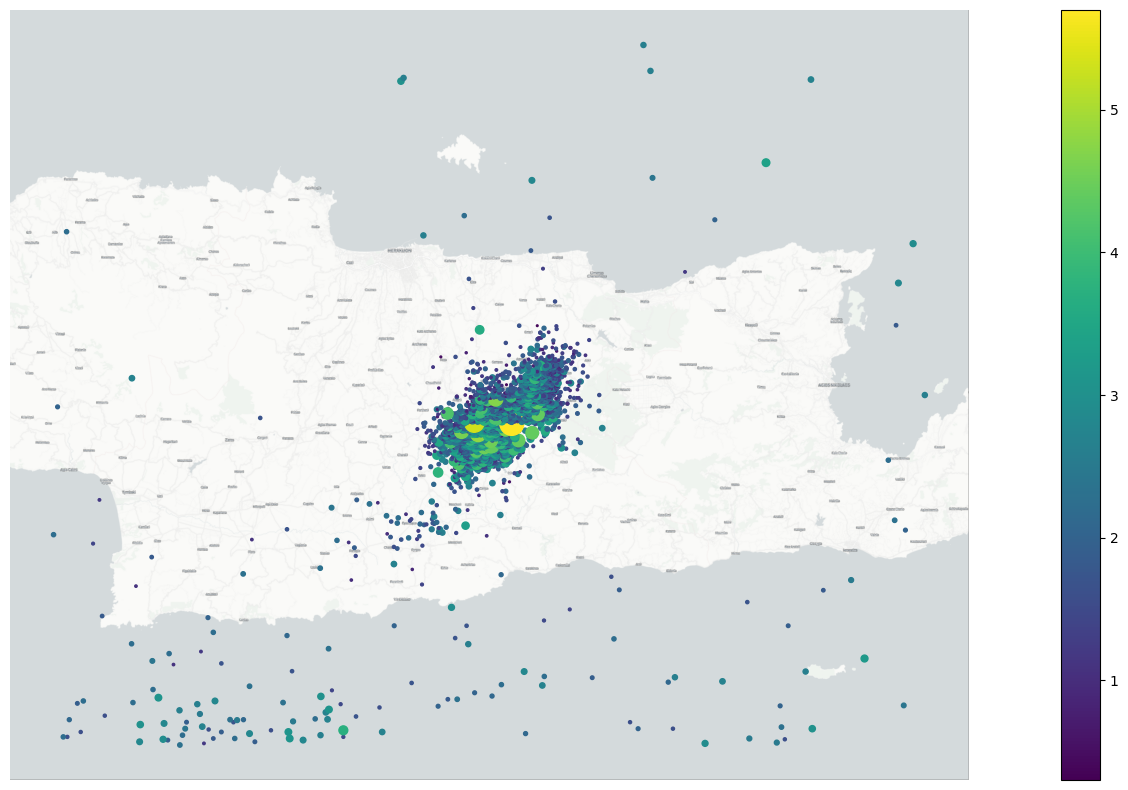

In [21]:
## plot the earthquakes and basemap

# reproject to Web Mercator, as web basemap most likely use this projection
quakes_wm = quakes.to_crs(epsg=3857)

ax = quakes_wm.plot(figsize=(24,10), column='MAGNITUDE(Local)', legend=True, **{'markersize': symbol_size})
cx.add_basemap(ax, zoom=12, source='Data/heraklion_no_labels.tif')
cx.add_basemap(ax, zoom=12, source='Data/heraklion_only_labels.tif')
ax.set_axis_off();